In [1]:
from fastai.vision.all import *
import segmentation_models_pytorch as smp
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [2]:
dataroot_dir = Path('dataset')

In [3]:
for walk in dataroot_dir.ls():
    print(repr(walk), walk.is_file())

Path('dataset/Data-sharing Agreement_FUGC2025.docx') True
Path('dataset/unlabeled_data') False
Path('dataset/labeled_data') False


In [4]:
# Configuration
CONFIG = {
    "epochs": 50,
    "batch_size": 4,
    "lr": 1e-3,
    "num_classes": 3,
    "save_dir": "models",
    "num_workers": 0,
    "in_channels": 3,
    "encoder": "efficientnet-b5",
    "encoder_weights":'imagenet',
    "temperature": 0.07,
    "cervical_classes": ['background','anterior', 'posterior'],
    "teacher_device": "cuda:0" if torch.cuda.is_available() else "cpu",
    "student_device": "cuda:1" if torch.cuda.is_available() else "cpu",
    "lambda_sat": 0.5,
    "lambda_aldc": 0.5
}

 # DataLoaders -> DataLoader(TrainingSet), DataLoader(ValidationSet) - Dataset - x, y - Datablock

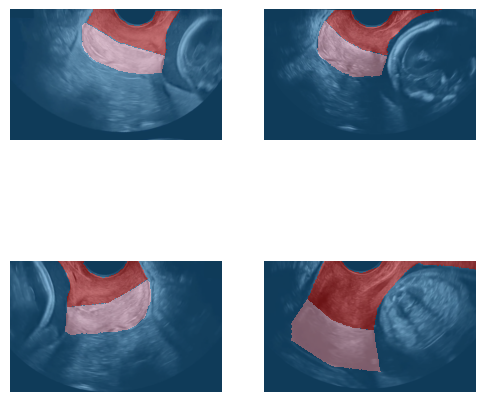

In [5]:
cervcal_datablocks = (ImageBlock, MaskBlock(codes=CONFIG['cervical_classes']))
def get_y(x): return(str(x).replace('images', 'labels'))

labeled_datablock = DataBlock(
    blocks= cervcal_datablocks,
    get_items=get_image_files,
    get_y = get_y,
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])
labeled_dls = labeled_datablock.dataloaders(dataroot_dir/'labeled_data/images', bs=CONFIG['batch_size'], num_workers=CONFIG['num_workers'], shuffle=True).to(CONFIG['teacher_device'])

labeled_dls.show_batch()

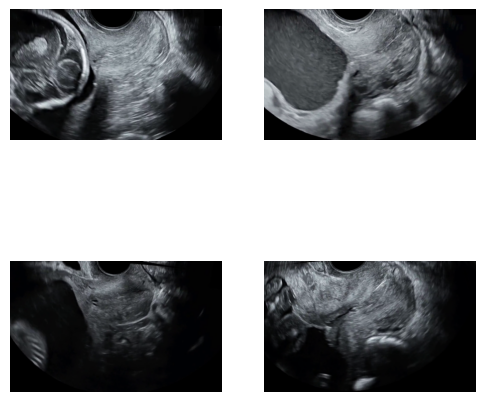

In [6]:
unlabeled_datablock = DataBlock(
    blocks= (ImageBlock, ),
    get_items=get_image_files,
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])
unlabeled_dls = unlabeled_datablock.dataloaders(dataroot_dir/'unlabeled_data/images', bs=CONFIG['batch_size'], num_workers=CONFIG['num_workers'], shuffle=True).to(CONFIG['student_device'])

unlabeled_dls.show_batch()

In [7]:
class TSNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = smp.DeepLabV3Plus(
            encoder_name=CONFIG['encoder'],
            encoder_weights=CONFIG['encoder_weights'],
            in_channels=CONFIG['in_channels'],
            classes=CONFIG['num_classes'],
            activation=None
        )
    def forward(self, x):
        x = self.model(x)
        return x


In [8]:
teacher_net = TSNet().to(CONFIG['teacher_device'])

In [9]:
learn = Learner(labeled_dls, teacher_net, loss_func=FocalLossFlat(axis=1), metrics=[foreground_acc, DiceMulti(axis=1)],opt_func=ranger).to_fp16()

In [10]:
learn.fit_one_cycle(CONFIG['epochs']//2, CONFIG['lr'])

epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.590546,0.492354,0.380940,0.108263,00:02
1,0.570175,0.483257,0.416325,0.187942,00:01
2,0.518118,0.432882,0.648090,0.476137,00:01
3,0.443612,0.373618,0.742825,0.659492,00:01
4,0.359095,0.269597,0.812627,0.756163,00:01
5,0.289399,0.149927,0.787779,0.800742,00:01
6,0.237342,0.116490,0.837132,0.843815,00:01
7,0.196315,0.081136,0.826174,0.850141,00:01
8,0.164299,0.062572,0.884636,0.896470,00:01
9,0.139969,0.049324,0.892556,0.917065,00:01


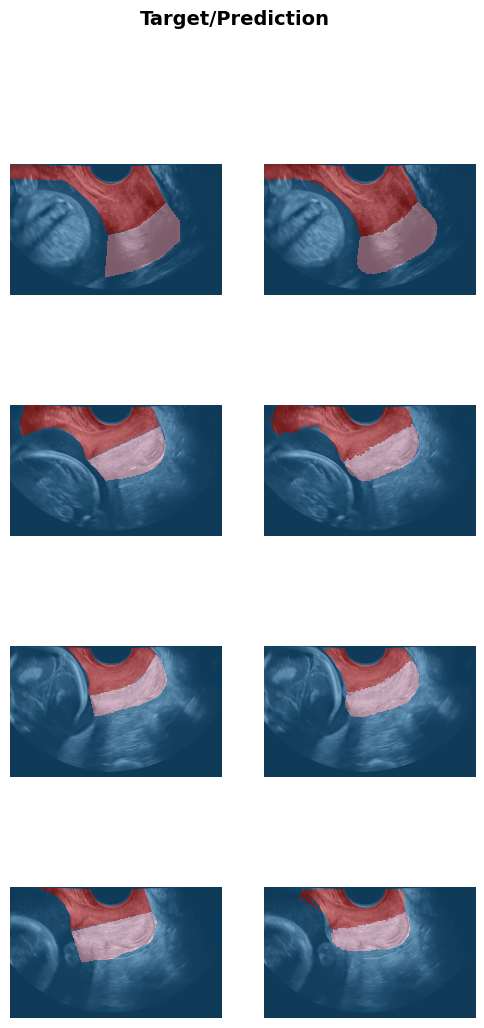

In [11]:
learn.show_results()

In [12]:
learn.unfreeze()
learn.fit_one_cycle(CONFIG['epochs']//2, slice(CONFIG['lr']/400, CONFIG['lr']/4))

epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.024363,0.022460,0.931304,0.952572,00:01
1,0.024261,0.022457,0.929200,0.951769,00:01
2,0.024540,0.022259,0.932433,0.951660,00:01
3,0.024036,0.022474,0.925785,0.949431,00:01
4,0.023445,0.023320,0.912458,0.944528,00:01
5,0.023514,0.021649,0.928174,0.948904,00:01
6,0.023410,0.021506,0.944547,0.950816,00:01
7,0.023217,0.021402,0.940113,0.949876,00:01
8,0.022887,0.020868,0.931318,0.949949,00:01
9,0.022606,0.020141,0.934523,0.952913,00:01


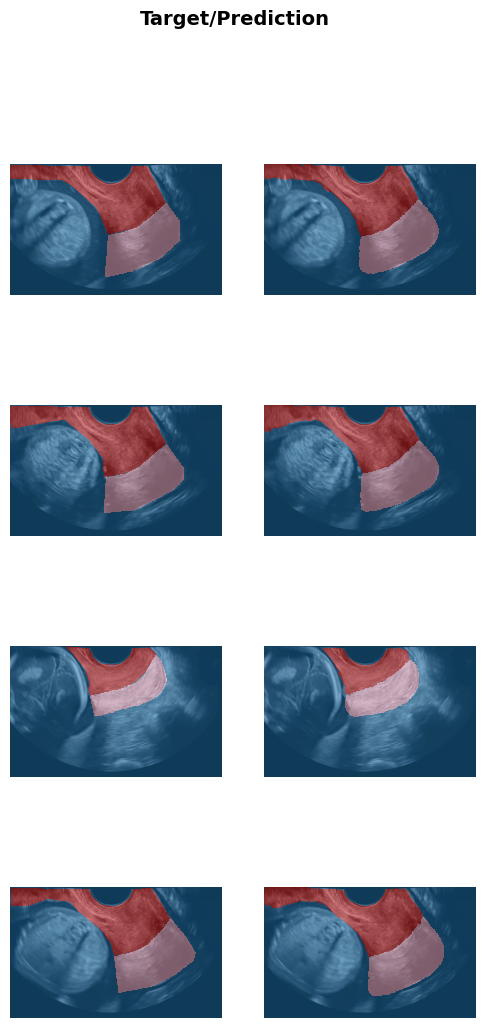

In [13]:
learn.show_results()

In [14]:
def model_equals(model1: torch.nn.Module, model2: torch.nn.Module, atol=1e-7, rtol=0):
    """
    Returns True if all corresponding parameters in model1 and model2 
    are close within the specified tolerance; otherwise False.
    """
    for p1, p2 in zip(model1.parameters(), model2.parameters()):
        if not torch.allclose(p1.data, p2.data, atol=atol, rtol=rtol):
            return False
    return True

In [15]:
same_weights = model_equals(teacher_net.model, learn.model)
print("Do teacher_net.model and learn.model have the same weights?", same_weights)

Do teacher_net.model and learn.model have the same weights? True


In [16]:
student_net = TSNet().to(CONFIG['student_device'])
# Copy just the underlying segmentation model’s weights:
student_net.model.load_state_dict(teacher_net.model.state_dict())

<All keys matched successfully>

In [17]:
same_weights = model_equals(teacher_net.model, student_net.model.to(CONFIG['teacher_device']))
print("Do teacher_net.model and student_net.model have the same weights?", same_weights)
student_net.model=student_net.model.to(CONFIG['student_device'])

Do teacher_net.model and student_net.model have the same weights? True


In [18]:
print(next(teacher_net.parameters()).device)

cuda:0


In [19]:
print(next(student_net.parameters()).device)

cuda:1


In [20]:
def sat_loss(anchor, pos, neg, temperature=0.07):
    # Dot products for anchor-positive and anchor-negative
    sim_pos = (anchor * pos).sum(dim=1) / temperature
    sim_neg = (anchor * neg).sum(dim=1) / temperature
    
    # SAT Loss is based on softmax cross-entropy
    logits = torch.stack([sim_pos, sim_neg], dim=1)
    labels = torch.zeros(anchor.size(0), dtype=torch.long, device=anchor.device)
    print(logits.shape, labels.shape)
    return F.cross_entropy(logits, labels)

def compute_hardness_map(logits):
    probs = torch.softmax(logits, dim=1)
    ent = -torch.sum(probs * torch.log(probs + 1e-8), dim=1, keepdim=True)
    return ent

def aldc_loss(features, labels, mask, temperature=0.07):
    B, C, H, W = features.shape
    features_2d = features.permute(0,2,3,1).reshape(-1, C) 
    labels_2d = labels.reshape(-1)     
    mask_2d = mask.reshape(-1) > 0.5

    idxs = torch.where(mask_2d)[0]
    if len(idxs) < 2:
        return torch.tensor(0.0, device=features.device)  # no "hard" region

    # Pick random anchor in the masked region
    anchor_idx = idxs[torch.randint(0, len(idxs), (1,))]
    anchor_feat = features_2d[anchor_idx]  # shape (C,)
    anchor_label = labels_2d[anchor_idx]
    same_label_idx = idxs[(labels_2d[idxs] == anchor_label)]
    if len(same_label_idx) < 2:
        return torch.tensor(0.0, device=features.device)
    pos_idx = same_label_idx[torch.randint(0, len(same_label_idx), (1,))]
    pos_feat = features_2d[pos_idx]
    diff_label_idx = idxs[(labels_2d[idxs] != anchor_label)]
    if len(diff_label_idx) < 1:
        return torch.tensor(0.0, device=features.device)
    neg_idx = diff_label_idx[torch.randint(0, len(diff_label_idx), (1,))]
    neg_feat = features_2d[neg_idx]

    # Same form as sat_loss
    sim_pos = (anchor_feat * pos_feat).sum() / temperature
    sim_neg = (anchor_feat * neg_feat).sum() / temperature
    logits = torch.stack([sim_pos, sim_neg], dim=0).unsqueeze(0)
    labels_val = torch.zeros(1, dtype=torch.long, device=features.device)

    return F.cross_entropy(logits, labels_val)

In [21]:
for (xl, yl), xu in zip(labeled_dls[0], unlabeled_dls[0]):
    # Move student batch to student device
    xl, yl = xl.to(CONFIG['student_device']), yl.to(CONFIG['student_device'])
    logits_l = student_net(xl)
    sup_loss = FocalLossFlat(axis=1)(logits_l, yl)
    print(sup_loss)
    # Move unlabeled batch to teacher device
    x_u = xu[0]
    
    # Now move that tensor to the teacher's device
    x_u = x_u.to(CONFIG['teacher_device'])

    # Then pass x_u to the teacher_net
    with torch.no_grad():
        logits_u_teacher = teacher_net(x_u)
        pseudo_labels = torch.argmax(logits_u_teacher, dim=1)
        print(logits_u_teacher.shape,pseudo_labels.shape)

    # Student forward on unlabeled data
    pseudo_labels = pseudo_labels.to(CONFIG['student_device'])
    x_u = x_u.to(CONFIG['student_device'])
    logits_u_student = student_net(x_u)
    unsup_loss = FocalLossFlat(axis=1)(logits_u_student, pseudo_labels)
    print(unsup_loss)

    # Features for SAT loss
    features_student_u = F.adaptive_avg_pool2d(logits_u_student, (1,1)).squeeze(-1).squeeze(-1)
    features_teacher_u = F.adaptive_avg_pool2d(logits_u_teacher, (1,1)).squeeze(-1).squeeze(-1)
    print('Logits')
    print(logits_u_student.shape, logits_u_teacher.shape)
    print('Features')
    print(features_student_u.shape, features_teacher_u.shape)

    # Negative examples by shuffling
    batch_size = features_student_u.size(0)
    indices = torch.randperm(batch_size, device=CONFIG['student_device'])
    neg_features = features_student_u[indices]

    print(neg_features.shape)

    # SAT loss
    # First move teacher features to student device
    features_teacher_u = features_teacher_u.to(CONFIG['student_device'])
    sat_loss_val = sat_loss(features_student_u, features_teacher_u, neg_features, CONFIG['temperature'])
    print(sat_loss_val)

    # ALDC loss on labeled data (using hardness map from teacher)
    with torch.no_grad():
        xl = xl.to(CONFIG['teacher_device'])
        logits_l_hard = teacher_net(xl)

    hardness_map = compute_hardness_map(logits_l_hard)
    mask = (hardness_map > 0.5).float()

    mask = mask.to(CONFIG['student_device'])
    aldc_val = aldc_loss(logits_l, yl.unsqueeze(1), mask, CONFIG['temperature'])

    # Total loss
    total_loss = sup_loss + unsup_loss + CONFIG['lambda_sat']*sat_loss_val + CONFIG['lambda_aldc']*aldc_val

    
    break

TensorBase(0.0161, device='cuda:1', grad_fn=<AliasBackward0>)
torch.Size([4, 3, 336, 544]) torch.Size([4, 336, 544])
TensorBase(0.0176, device='cuda:1', grad_fn=<AliasBackward0>)
Logits
torch.Size([4, 3, 336, 544]) torch.Size([4, 3, 336, 544])
Features
torch.Size([4, 3]) torch.Size([4, 3])
torch.Size([4, 3])
torch.Size([4, 2]) torch.Size([4])
TensorImage(0.9741, device='cuda:1', grad_fn=<AliasBackward0>)


In [22]:
t = torch.randn(3,4); t.shape

torch.Size([3, 4])

In [25]:
tu = t.unsqueeze(1); tu.shape

torch.Size([3, 1, 4])

In [28]:
FocalLossFlat??

Init signature:
FocalLossFlat(
    *args,
    gamma: 'float' = 2.0,
    axis: 'int' = -1,
    weight=None,
    reduction='mean',
    **kwargs,
)
Source:        
class FocalLossFlat(BaseLoss):
    """
    Same as CrossEntropyLossFlat but with focal paramter, `gamma`. Focal loss is introduced by Lin et al. 
    https://arxiv.org/pdf/1708.02002.pdf. Note the class weighting factor in the paper, alpha, can be 
    implemented through pytorch `weight` argument passed through to F.cross_entropy.
    """
    y_int = True # y interpolation
    @use_kwargs_dict(keep=True, weight=None, reduction='mean')
    def __init__(self, 
        *args, 
        gamma:float=2.0, # Focusing parameter. Higher values down-weight easy examples' contribution to loss
        axis:int=-1, # Class axis
        **kwargs
    ):
        super().__init__(FocalLoss, *args, gamma=gamma, axis=axis, **kwargs)
        
    def decodes(self, x:Tensor) -> Tensor: 
        "Converts model output to target format"
        retur